In [1]:
import sys

if r'D:\Workspace\Pedestrian-Dead-Reckoning' not in sys.path:
    sys.path.append(r'D:\Workspace\Pedestrian-Dead-Reckoning')

In [2]:
from pedestrian_data import PedestrianDataset, PedestrianLocus, default_low_pass_filter

dataset = PedestrianDataset(["Magnetometer"], window_size=200, 
                            acceleration_filter=default_low_pass_filter)

for name, locus in dataset:
    print("正在遍历移动轨迹{}... \n".format(name))

    for sample in locus:
        for k, v in sample.items():
            print(k + ":" + str(v.shape))
        break

    print(locus.columns_info())
    break

正在遍历移动轨迹NorthEastSouthWest... 

Accelerometer:(200, 4)
Gyroscope:(200, 4)
Magnetometer:(200, 4)
Linear Acceleration:(200, 4)
Location:(200, 9)
{'Accelerometer': Index(['Time (s)', 'Accelerometer.Acceleration x (m/s^2)',
       'Accelerometer.Acceleration y (m/s^2)',
       'Accelerometer.Acceleration z (m/s^2)'],
      dtype='object'), 'Gyroscope': Index(['Time (s)', 'Gyroscope.Gyroscope x (rad/s)',
       'Gyroscope.Gyroscope y (rad/s)', 'Gyroscope.Gyroscope z (rad/s)'],
      dtype='object'), 'Magnetometer': Index(['Time (s)', 'Magnetometer.Magnetic field x (µT)',
       'Magnetometer.Magnetic field y (µT)',
       'Magnetometer.Magnetic field z (µT)'],
      dtype='object'), 'Linear Acceleration': Index(['Time (s)', 'Linear Acceleration.Linear Acceleration x (m/s^2)',
       'Linear Acceleration.Linear Acceleration y (m/s^2)',
       'Linear Acceleration.Linear Acceleration z (m/s^2)'],
      dtype='object'), 'Location': Index(['location_time', 'Latitude (°)', 'Longitude (°)', 'Heig

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号’-'显示为方块的问题

## 姿态测试

In [4]:
from locus_predictor.mature_locus_predictor import predict

def calculate_attitude (sample):
    positions, properties = predict(dataset[sample])
    thetas, phis = properties["thetas"], properties["phis"] 
    
    fig, axs = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(8, 6))
    fig.tight_layout(pad=5)
    axs[0].set_theta_zero_location("N")
    axs[0].plot(thetas, dataset[sample].frame["Time (s)"][1:-1])
    axs[0].set_title("极角θ", va='bottom')
    axs[0].grid(True)

    axs[1].plot(phis, dataset[sample].frame["Time (s)"][1:-1])
    axs[1].set_title("仰角φ", va='bottom')
    axs[1].grid(True)

In [5]:
# calculate_attitude("图书馆（东开始，向北，折返）", -1/2 * np.pi, 1/4 * np.pi)

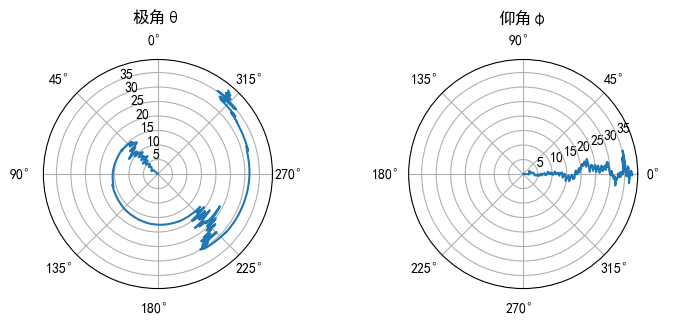

In [6]:
calculate_attitude("图书馆2")

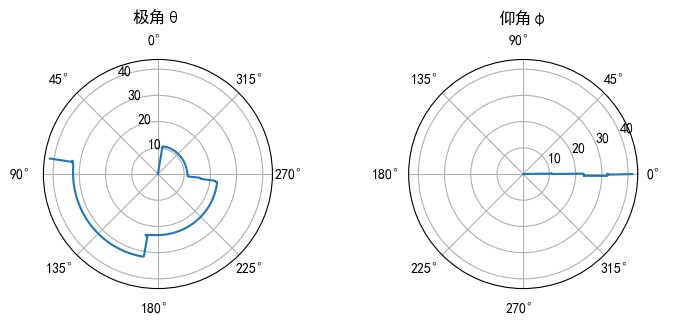

In [7]:
calculate_attitude("NorthEastSouthWest")

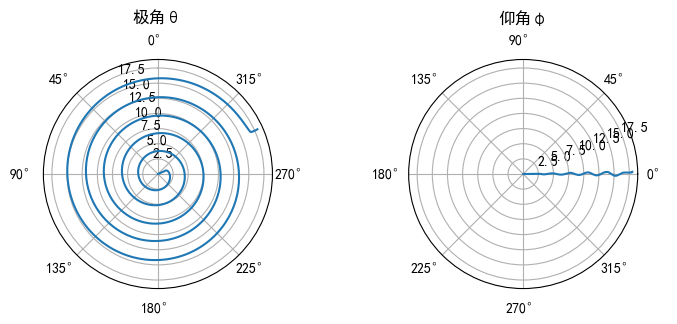

In [8]:
calculate_attitude("电脑椅转转转")

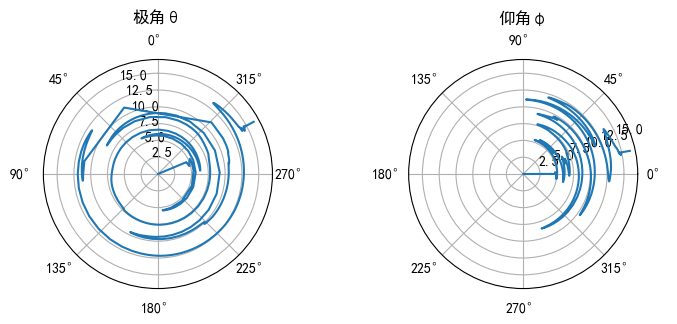

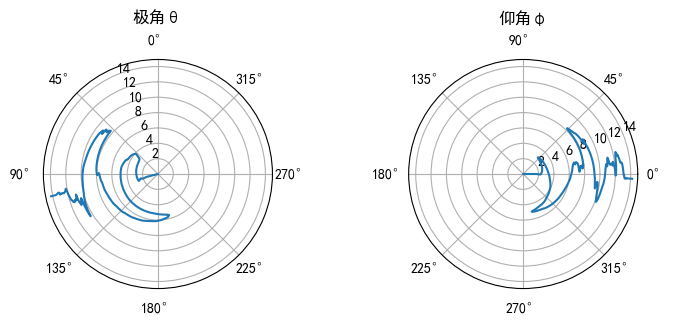

In [9]:
calculate_attitude("乱晃手腕（初末相同）1")
calculate_attitude("乱晃手腕（初末相同）2")

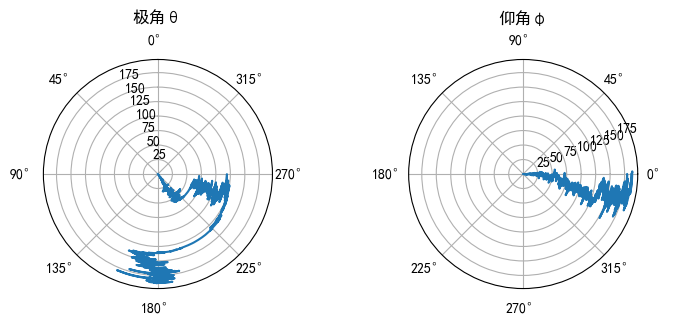

In [10]:
calculate_attitude("平持手机走路")

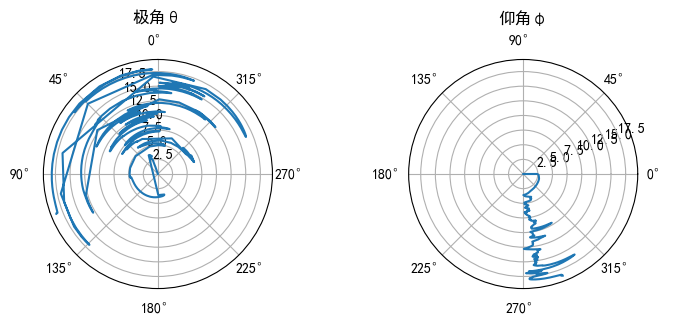

In [11]:
calculate_attitude("奇异面")

## 轨迹绘制

In [17]:
def calculate_locus (sample):
    locus = dataset[sample]
    positions, properties = predict(locus, walk=True)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    buffer_frame = locus.relative_location[["relative_x (m)", "relative_y (m)"]]
    x = buffer_frame["relative_x (m)"].to_numpy()
    y = buffer_frame["relative_y (m)"].to_numpy()
    
    if len(x) > 0:
        axs[0].set_title("GPS数据")
        axs[0].set_xlabel("x (m)")
        axs[0].set_ylabel("y (m)")
        axs[0].text(x[0], y[0], 's', fontsize=10)
        axs[0].text(x[-1], y[-1], 'e', fontsize=10)
        axs[0].plot(x, y,, label=sample)
        axs[0].legend()
    
    x = properties["walk_positions"][:, 0]
    y = properties["walk_positions"][:, 1]
    axs[1].set_title("步频步幅预测")
    axs[1].set_xlabel("x (m)")
    axs[1].set_ylabel("y (m)")
    axs[1].text(x[0], y[0], 's', fontsize=10)
    axs[1].text(x[-1], y[-1], 'e', fontsize=10)
    axs[1].plot(x, y, label=sample)
    axs[1].legend()
    plt.show()
    
# caculate_locus("随机漫步1")
# caculate_locus("图书馆（东开始，向北，折返）", -1/2 * np.pi, 1/4 * np.pi)

In [18]:
def calculate_direction (sample):
        positions, properties = predict(dataset[sample], walk=True)
        thetas, phis, time = properties["thetas"], properties["phis"], properties["time"] 
        walk_directions, walk_time = properties["walk_directions"], properties["walk_time"]
        
        fig, axs = plt.subplots(3, 1, subplot_kw={'projection': 'polar'}, figsize=(8, 16))
        fig.tight_layout(pad=5)
        axs[0].set_theta_zero_location("N")
        axs[0].plot(thetas, time)
        axs[0].set_title("极角θ", va='bottom')
        axs[0].grid(True)

        axs[1].plot(phis, time)
        axs[1].set_title("仰角φ", va='bottom')
        axs[1].grid(True)
        
        axs[2].plot(walk_directions, walk_time)
        axs[2].set_theta_zero_location("N")
        axs[2].set_title("行走方向", va='bottom')
        axs[2].grid(True)

In [19]:
def calculate_v_a (sample):
    positions, properties = predict(dataset[sample], walk=True)
    speeds, accelerations, thetas, phis, time, peaks = properties["speeds"], properties["accelerations"], \
        properties["thetas"], properties["phis"], properties["time"], properties["peaks"]
    
    fig, axs = plt.subplots(3, 1, figsize=(8, 10))
    fig.tight_layout(pad=5)
    vx = speeds[:, 0]
    ax = accelerations[:, 0]
    vy = speeds[:, 1]
    ay = accelerations[:, 1]
    vz = speeds[:, 2]
    az = accelerations[:, 2]

    axs[0].set_title("x方向（N-S）")
    axs[0].set_xlabel("时间")
    axs[0].plot(time, vx, label="速度")
    axs[0].plot(time, ax, label="加速度", alpha=0.5)
    axs[0].legend()

    axs[1].set_title("y方向（E-W）")
    axs[1].set_xlabel("时间")
    axs[1].plot(time, vy, label="速度")
    axs[1].plot(time, ay, label="加速度", alpha=0.5)
    axs[1].legend()

    axs[2].set_title("z方向（竖直）")
    axs[2].set_xlabel("时间")
    axs[2].plot(time, vz, label="速度")
    axs[2].plot(time, az, label="加速度", alpha=0.5)
    axs[2].scatter(x=time[peaks], y=vz[peaks], label="步频", s=5, color="red")
    axs[2].legend()
    plt.show()

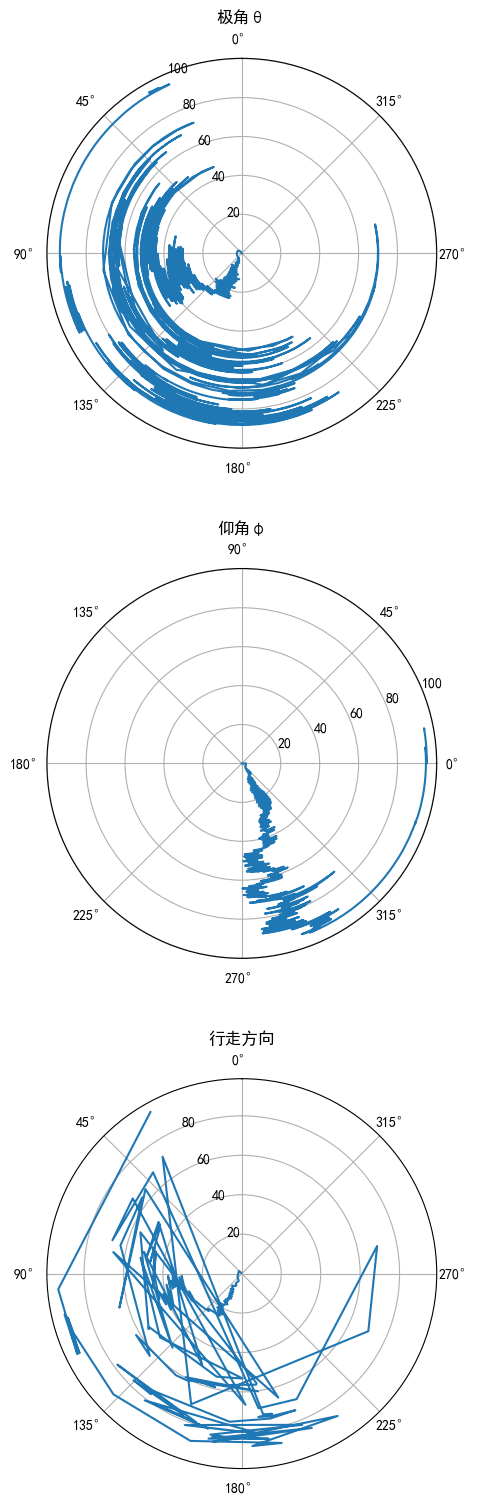

In [20]:
calculate_direction("图书馆巡回1")

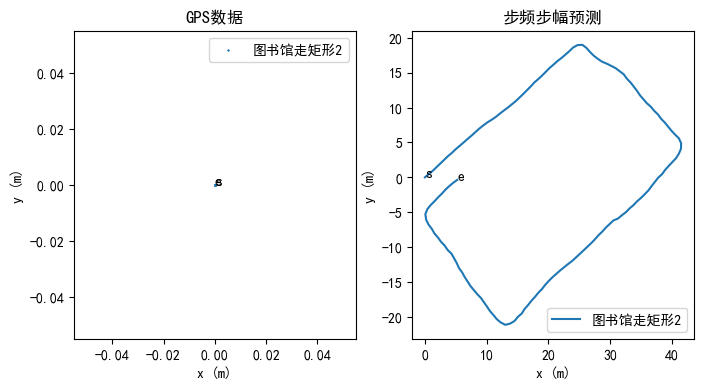

In [21]:
calculate_locus("图书馆走矩形2")

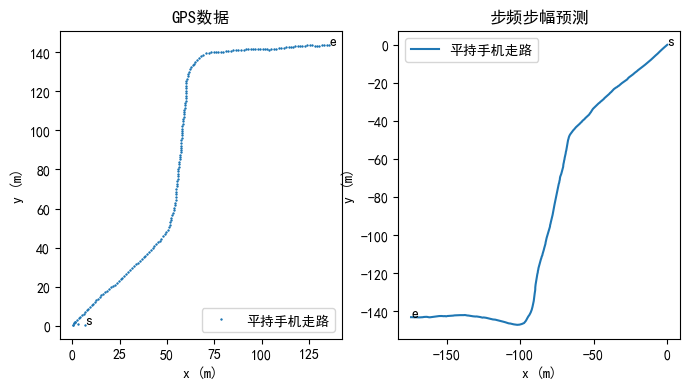

In [22]:
calculate_locus("平持手机走路")

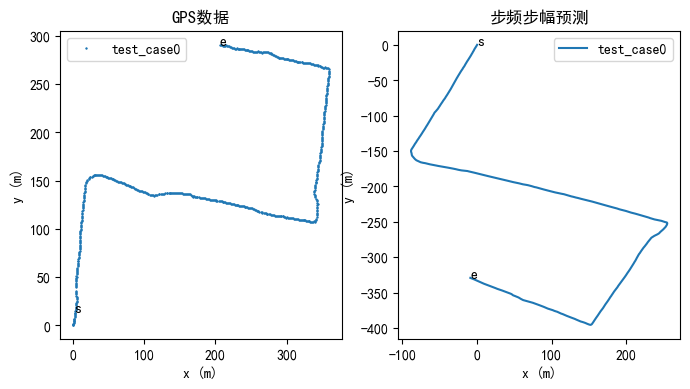

In [23]:
calculate_locus("test_case0")
# calculate_direction("test_case0")

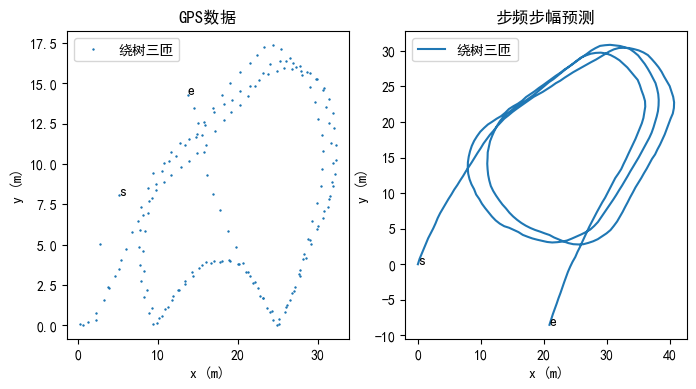

In [24]:
calculate_locus("绕树三匝")